In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy import table
from astropy.table import Table, join, unique
from astropy.io import ascii
import astropy.io.fits as pyfits
from astropy.wcs import WCS
import os


In [2]:
# import SNeCO data
SNe_Gal_File = '../Data/3.SNe+GalData.csv'
SNe_Gal_Data = Table.read(SNe_Gal_File, format='csv') 

SNe_Gal_Data[0]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,PACovFile,IFRFile,MixedMaps,IFRResizedMaps,MassMaps
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str80,str112,str97,str37,str54,str35
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/ESO097-013_alphaCO21_scaling.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_coverage2d.fits,/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/z0mgs/eso097-013_w1_gauss7p5.fits,../Data/MixedMaps/circinus_Mixed.fits,../Data/ReprojectedInfraredMaps/circinus_reshaped.fits,../Data/MassMaps/circinus_Mass.fits


In [3]:
# File location: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc7793/ngc7793_7m+tp_co21_150pc_broad_mom0.fits

In [4]:
# isolate unique galaxies and their telescope orientation
galData = unique(SNe_Gal_Data,"galaxy")
gals, telOrient = galData["galaxy"], galData["telOrient"]

# for i in range(len(gals)):
#     print(gals[i], telOrient[i])

In [5]:
fileList, errFile = [],[]

def fileStr(galaxy, telOrient, res, mapType="img"):
             
    if mapType == "img":
        return("/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/" + galaxy + "/" + galaxy + "_" + telOrient + "_co21_" + str(res) + "pc_broad_mom0.fits")
    else:
        return("/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/" + galaxy + "/" + galaxy + "_" + telOrient + "_co21_" + str(res) + "pc_broad_emom0.fits")

for i in range(len(gals)):
    fileList.append(fileStr(gals[i], telOrient[i], 90))
    errFile.append(fileStr(gals[i], telOrient[i], 90, mapType="err"))


In [6]:
# group each galaxy's SNe data

gal_groups = SNe_Gal_Data.group_by('galaxy')
galaxies = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)
#print(gals)

images, err, name, types, ras, decs = [],[],[],[],[],[]
for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(fileList[i])
    err.append(errFile[i])
    SNnames.append(gal_groups["SN_name"][indices[i]])
    SNtypes.append(gal_groups["SN_type"][indices[i]])
    SNras.append(gal_groups["SN_ra"][indices[i]])
    SNdecs.append(gal_groups["SN_dec"][indices[i]])
    j = 1
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["SN_name"][indices[i]+j])
        SNtypes.append(gal_groups["SN_type"][indices[i]+j])
        SNras.append(gal_groups["SN_ra"][indices[i]+j])
        SNdecs.append(gal_groups["SN_dec"][indices[i]+j])
        j += 1
    name.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)    
  

In [7]:
def getPlotStuff(gal, image, error, names, types, ras, decs):
    plots, sigma, wcss, hdus, beamsizes, plotAspect, ppb, corner, SNnames, SNtypes, SNras, SNdecs, SNgals = [],[],[],[],[],[],[],[],[],[],[],[],[]

    for i in range(len(gal)):

        if os.path.isfile(image[i]):
            img = image[i]
            err=error[i]

            co_hdu = pyfits.open(img)
            hdus.append(co_hdu)

            beamMaj = co_hdu[0].header['BMAJ']
            beamMin = co_hdu[0].header['BMIN']
            if(beamMaj==beamMin):
                beamsizes.append(beamMaj)
            else:
                beamsizes.append(0.0)

            co_map = co_hdu[0].data
            plots.append(co_map)
            err_hdu = pyfits.open(err)
            err_map = err_hdu[0].data
            sig_map = co_map / err_map
            sigma.append(sig_map)
            w = WCS(co_hdu[0].header, naxis=2)
            wcss.append(w)
            x = co_map.shape[0]
            y = co_map.shape[1]
            naxis    = w._naxis # size of image naxis[0] = x and [1] = y
            grid     = np.indices((naxis[1],naxis[0]))
            aspect = float(y)/float(x)
            cdelt = co_hdu[0].header['CDELT1']
            ppb.append(beamMaj/np.abs(cdelt))
            plotAspect.append(aspect)
            corner.append(x/15.0)
            
            SNnames.append(name[i])
            SNtypes.append(types[i])
            SNras.append(ras[i]) 
            SNdecs.append(decs[i])
            SNgals.append(gal[i])
            
        else:
            print("No 90 pc file for:",image[i])

    return(plots, sigma, wcss, hdus, beamsizes, plotAspect, ppb, corner, SNnames, SNtypes, SNras, SNdecs, SNgals)

In [8]:
# set up 90pc plots, wcs information, and make sigma maps for contours.

plots, sigma, wcss, hdus, beamsizes, plotAspect, ppb, corner, SNnames, SNtypes, SNras, SNdecs, SNgals = getPlotStuff(gals, images, err, name, types, ras, decs)



No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0253/ngc0253_7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1068/ngc1068_7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1087/ngc1087_12m+7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1097/ngc1097_12m+7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1365/ngc1365_12m+7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1511/ngc1511_12m+7m+tp_co21_90pc_broad_mom0.fits
No 90 pc file for: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1559/ngc1559_12m+7m+tp_co21

In [9]:
legendLabels = []

for i in range(len(SNnames)):
    legendlabel = []
    if len(SNnames[i]) > 1:
        for k in range(len(SNnames[i])):
            if SNtypes[i][k] == 'unclassified':
                label = SNnames[i][k] + ' '  + SNtypes[i][k]
            else:
                label = SNnames[i][k] + ' Type '  + SNtypes[i][k]
            legendlabel.append(label)
    else:
        if SNtypes[i][0] == 'unclassified':
            legendlabel.append(SNnames[i][0] + ' '  + SNtypes[i][0]) 
        else:        
            legendlabel.append(SNnames[i][0] + ' Type '  + SNtypes[i][0])
    legendLabels.append(legendlabel)
print(legendLabels)

print(beamsizes)


[['SN2013ej Type II'], ['SN1985P Type II'], ['SN1999em Type II'], ['SN2012A Type II'], ['SN1989B Type Ia', 'SN2016cok Type II', 'SN2009hd Type II', 'SN1973R Type II'], ['SN2012cg Type Ia'], ['SN2020nvb Type Ia'], ['SN1988M Type II', 'SN1960F Type Ia'], ['SN1983N Type Ib', 'SN1968L Type II', 'SN1923A Type II', 'SN1950B unclassified', 'SN1957D unclassified'], ['SN2007it Type II'], ['SN2005at Type Ic']]
[0.000524046763839167, 0.0003049153591757, 0.000440736765485248, 0.000474826902042118, 0.0004517319625788, 0.000316349305137, 0.000341498023587907, 0.0003482539090036, 0.001054523549320534, 0.000420262441416251, 0.000549160826003983]


<ipython-input-10-598ddf73b9f8>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  current_cmap.set_bad("black")
<ipython-input-10-598ddf73b9f8>:19: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plot)
<ipython-input-10-598ddf73b9f8>:19: RuntimeWarning: invalid value encountered in log10
  logplot = np.log10(plot)


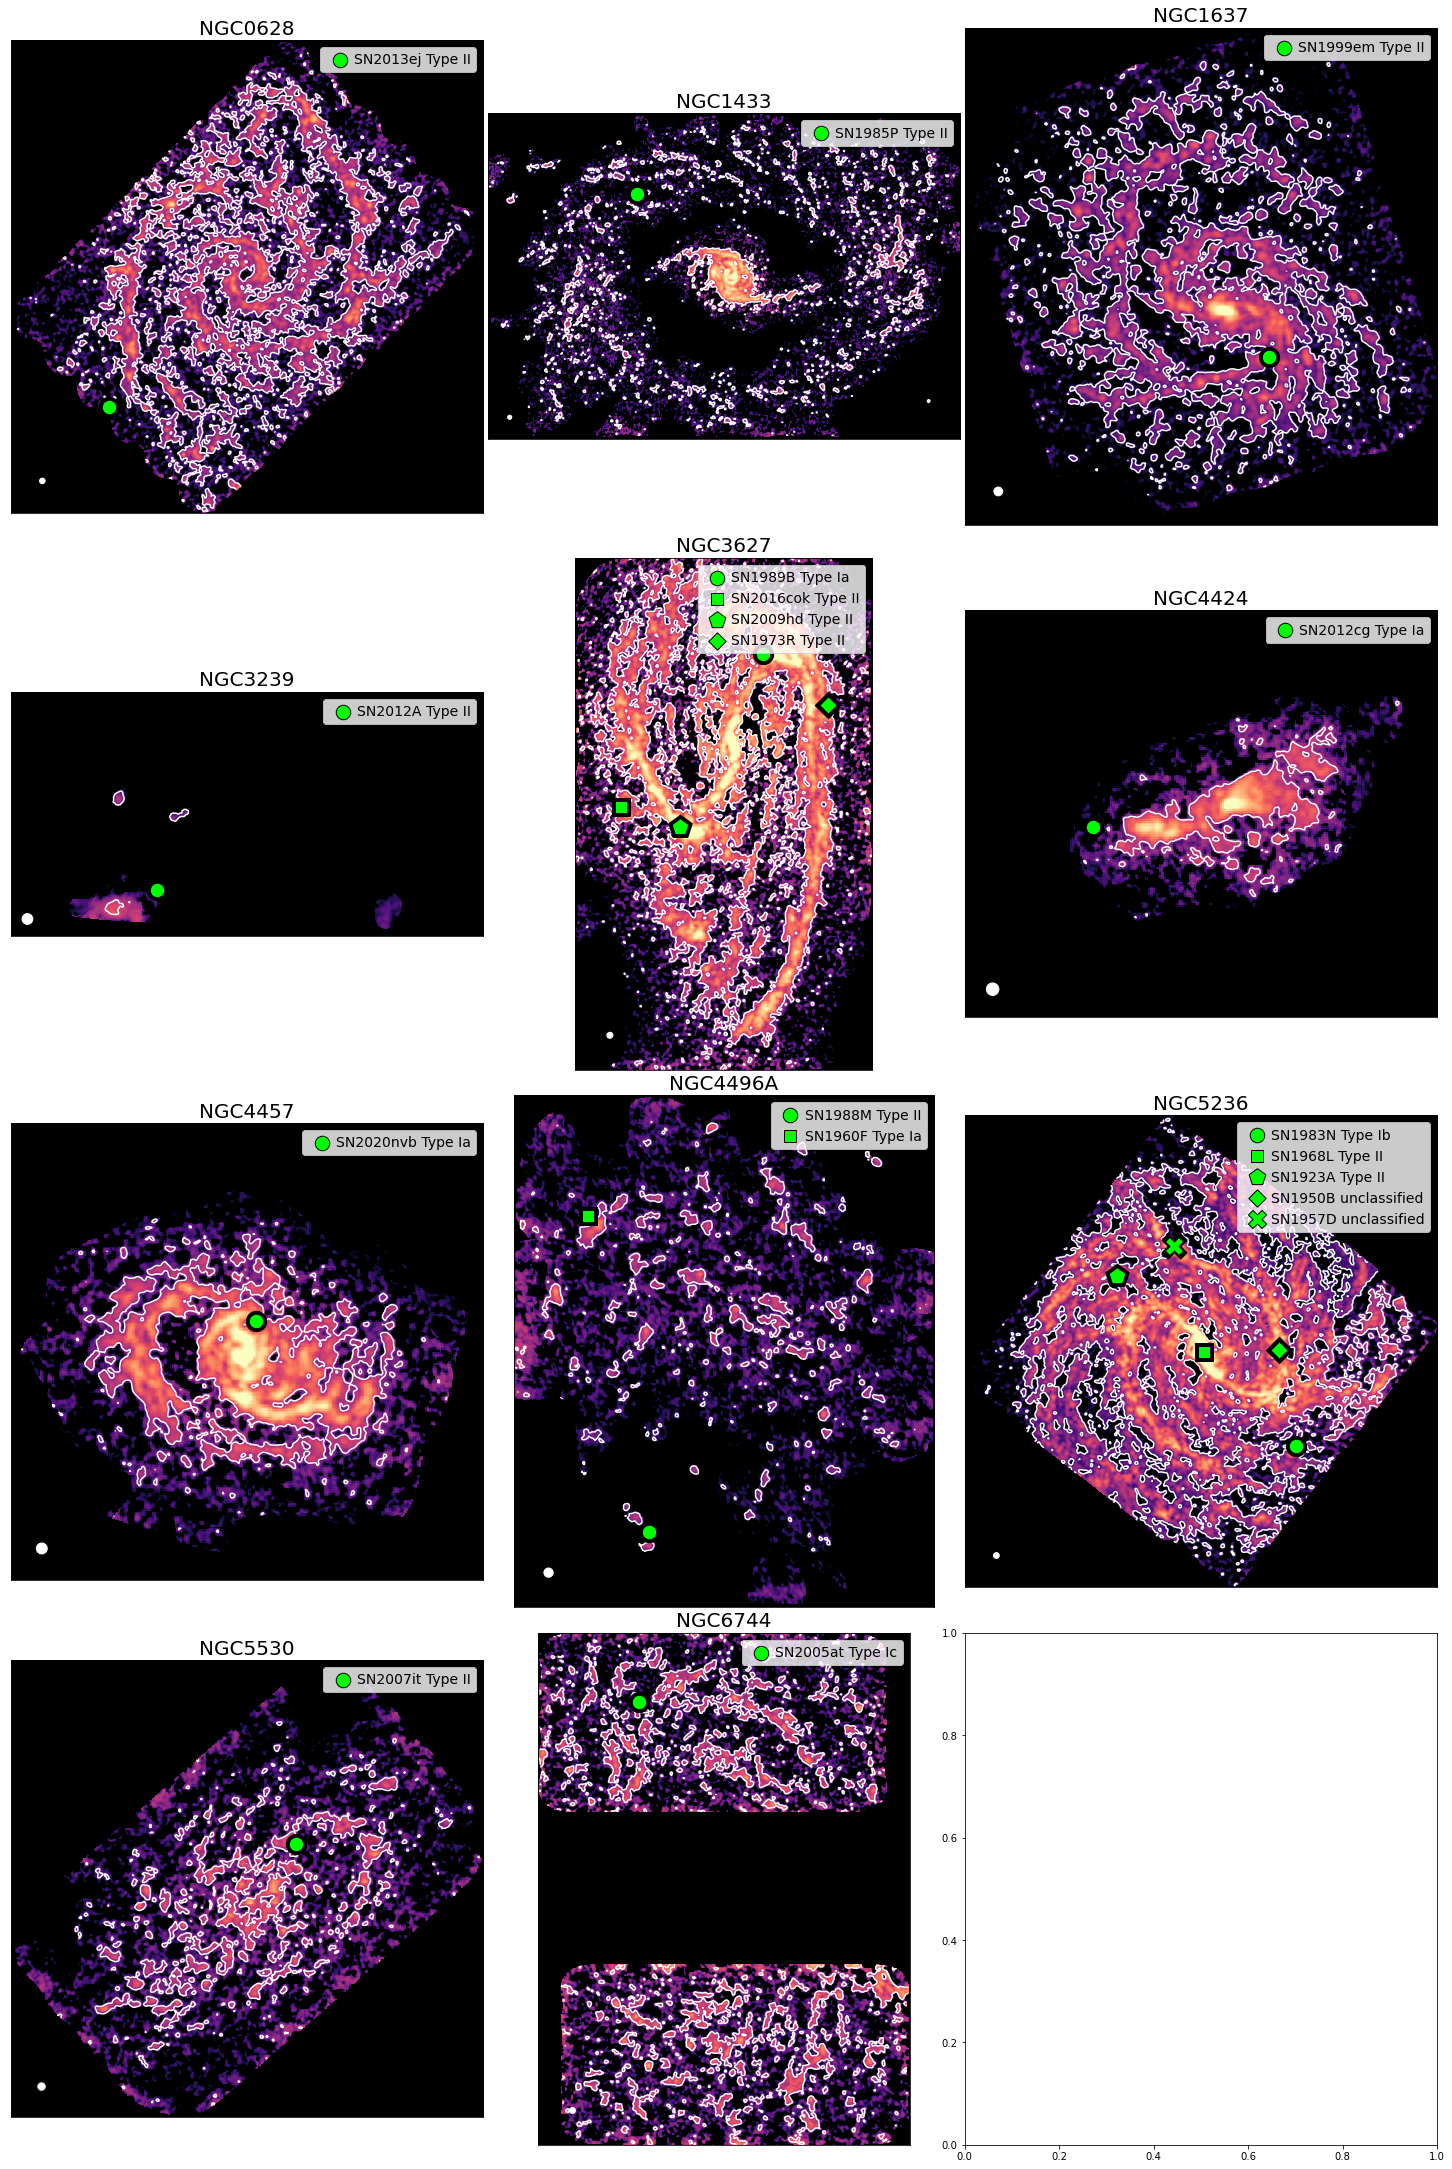

In [10]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "p", "D", "X", "H", "v"]
markerSizes  = [210,150,310,150,330,310,350]
markerEdges  = [410,350,610,350,630,610,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 30))
for plot in plots:
    draw_circle = plt.Circle((corner[m], corner[m]),ppb[m], fill = True, color = 'white')

    xArr, yArr = wcss[m].wcs_world2pix(SNras[m],SNdecs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest", vmin = -0.5, vmax = 2.0, zorder = 0)
    axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].add_patch(draw_circle)
    for n in range(len(SNdecs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerEdges[n], zorder=2)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], edgecolor="black", label = legendLabels[m][n], zorder = 2)
    axs[i][j].contour(sigma[m], [3], colors = ["white"], linestyles = ("-"), zorder = 1)
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/AllSNeInGalaxies_90pc.png", dpi=300)
   
print()

332.88275158091994 356.5798802757223
405 260 281 431
263.24229673205275 432.6964573080354
297 229 382 482
365.88111967572297 202.21655637994772
415 315 152 252
154.69283837673458 47.619850747664444
202 106 -2 97
77.58611724230103 114.68378471393544
126 28 64 164
183.7305638451553 193.683337841085
233 133 143 243
389.96883902948343 372.6813125394725
426 353 322 422
228.49829813441235 1000.8518579072179
250 206 950 1050


<ipython-input-16-5d815d9a464f>:50: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plot)
<ipython-input-16-5d815d9a464f>:50: RuntimeWarning: invalid value encountered in log10
  logplot = np.log10(plot)
<ipython-input-16-5d815d9a464f>:21: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plot)
<ipython-input-16-5d815d9a464f>:21: RuntimeWarning: invalid value encountered in log10
  logplot = np.log10(plot)


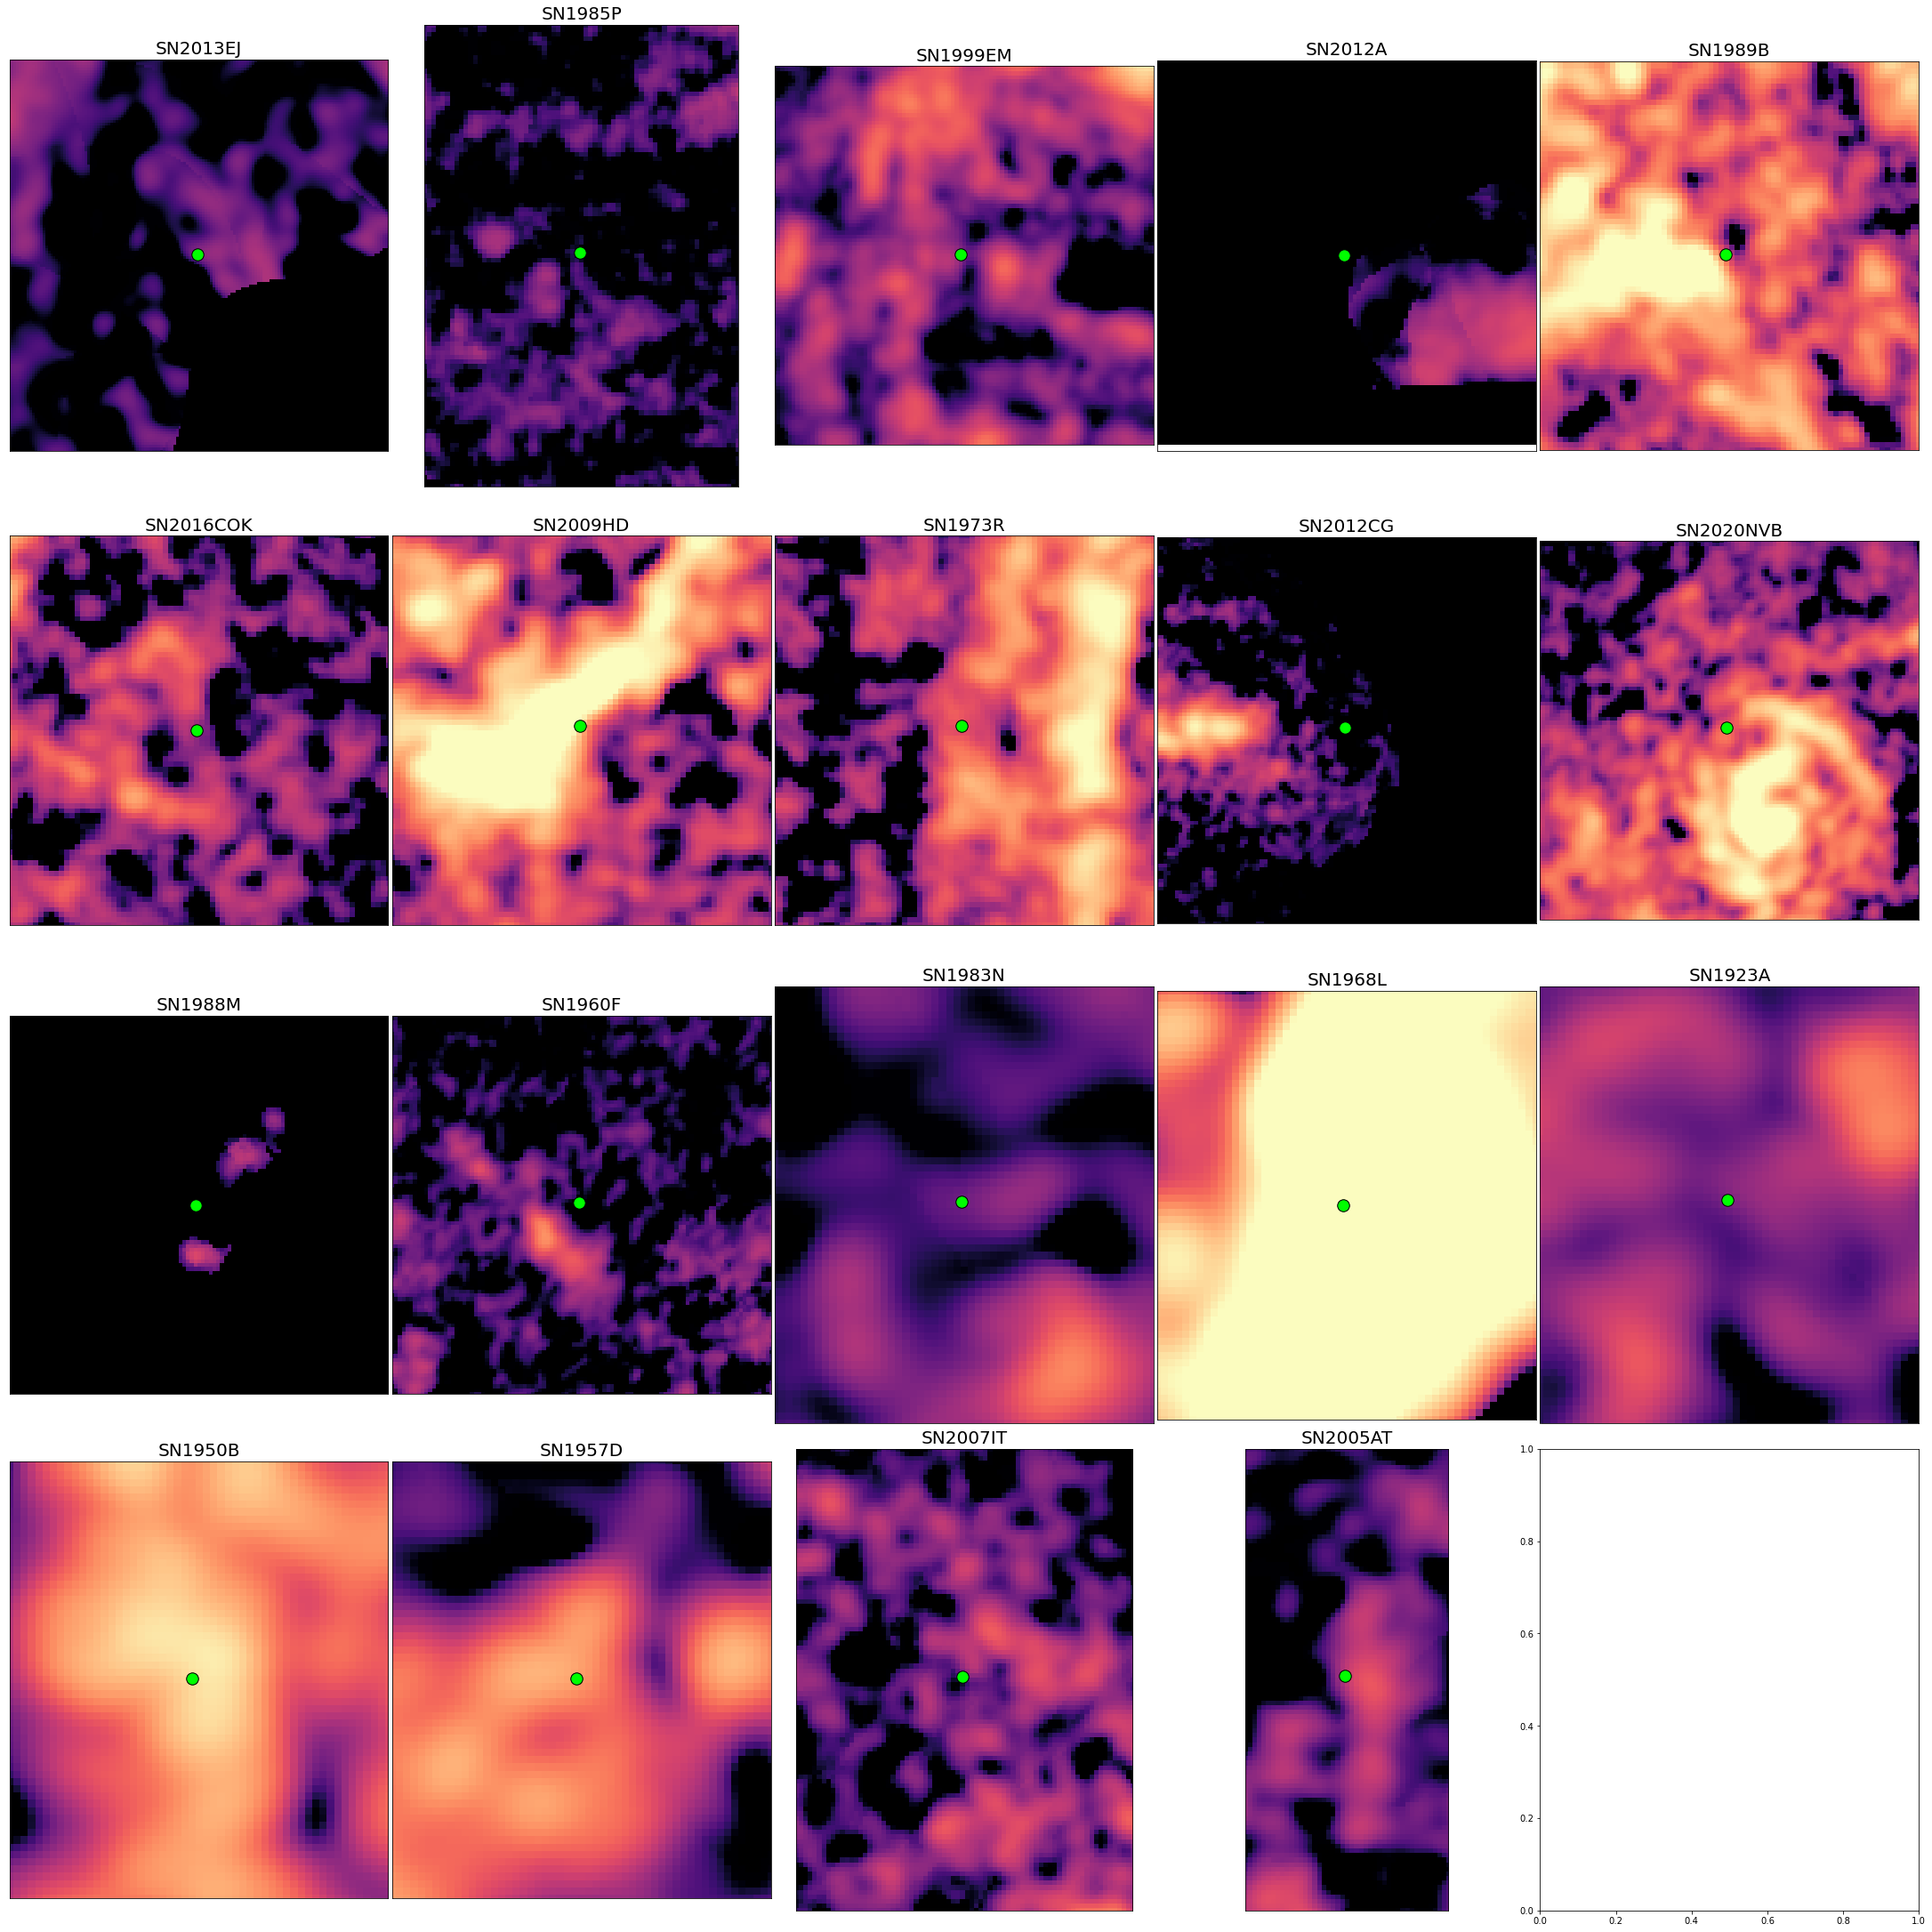

In [16]:

halfBox = 0.00416667 # 15' in degrees
m,n,p =0,0,0 # plot counters for total number, rows, columns
PLOTS_PER_ROW = 5
numSNe = 19
fig, axs = plt.subplots(math.ceil(numSNe/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(30, 30))

for j in range(len(SNgals)): # counter to count galaxy maps
    if  len(SNras[j]) > 1:
        for k in range(len(SNras[j])): # counter to count number of SN in each galaxy

            SNraStart  = SNras[j][k]  -  halfBox
            SNraEnd    = SNras[j][k]  +  halfBox
            SNdecStart = SNdecs[j][k] -  halfBox
            SNdecEnd   = SNdecs[j][k] +  halfBox

            xVal, yVal     = wcss[j].wcs_world2pix(SNras[j][k],SNdecs[j][k],0)
            xStart, yStart = wcss[j].wcs_world2pix(SNraStart, SNdecStart,0)
            xEnd, yEnd     = wcss[j].wcs_world2pix(SNraEnd, SNdecEnd,0)
            xStart, xEnd, yStart, yEnd = int(xStart), int(xEnd), int(yStart), int(yEnd)
            plot = plots[j]#[xStart:xEnd][yStart:yEnd]
            logplot = np.log10(plot)

            axs[m][n].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest", vmin = -0.5, vmax = 2.0, zorder = 0)
            axs[m][n].set_ylim(yStart,yEnd)
            axs[m][n].set_xlim(xStart,xEnd)
            axs[m][n].set_title(SNnames[j][k].upper(), fontsize=20)
            axs[m][n].set_xticks([])
            axs[m][n].set_yticks([])
            axs[m][n].scatter(xVal, yVal, color = "black", marker = "o", s = 160, zorder=2)
            axs[m][n].scatter(xVal, yVal, color = "lime", marker = "o", s = 180, edgecolor="black",zorder = 2)
            
            n+=1
            if n%PLOTS_PER_ROW==0:
                m+=1
                n=0
            p +=1
    else:
        SNraStart  = SNras[j][0]  -  halfBox
        SNraEnd    = SNras[j][0]  +  halfBox
        SNdecStart = SNdecs[j][0] -  halfBox
        SNdecEnd   = SNdecs[j][0] +  halfBox

        xVal, yVal     = wcss[j].wcs_world2pix(SNras[j][0],SNdecs[j][0],0)
        (print(xVal,yVal))
        xStart, yStart = wcss[j].wcs_world2pix(SNraStart, SNdecStart,0)
        xEnd, yEnd     = wcss[j].wcs_world2pix(SNraEnd, SNdecEnd,0)
        xStart, xEnd, yStart, yEnd = int(xStart), int(xEnd), int(yStart), int(yEnd)
        print(xStart, xEnd, yStart, yEnd)
        plot = plots[j]#[xStart:xEnd][yStart:yEnd]
        logplot = np.log10(plot)

        axs[m][n].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest", vmin = -0.5, vmax = 2.0, zorder = 0)
        axs[m][n].set_ylim(yStart,yEnd)
        axs[m][n].set_xlim(xStart,xEnd)

        axs[m][n].set_title(SNnames[j][0].upper(), fontsize=20)
        axs[m][n].set_xticks([])
        axs[m][n].set_yticks([])
        axs[m][n].scatter(xVal, yVal, color = "black", marker ="o", s = 160, zorder=2)
        axs[m][n].scatter(xVal, yVal, color = "lime", marker = "o", s = 180, edgecolor="black",zorder = 2)

        n+=1
        if n%PLOTS_PER_ROW==0:
            m+=1
            n=0
        p +=1

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/Zooms_90pc.pdf", dpi=300)
